## Import libraries and data 

In [23]:
import pandas as pd
import numpy as np
import cv2
import glob
# Keras to build the model
import keras
from keras import backend as K
from keras.models import Model, model_from_json
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input,BatchNormalization,LeakyReLU, Reshape
from tensorflow.keras.layers import Input, Dense, Concatenate
from keras.layers.core import Flatten, Dense, Dropout, Activation
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from keras.models import load_model
import matplotlib.pyplot as plt
from matplotlib import pyplot
from keras.optimizers import Adadelta, RMSprop,SGD,Adam
from tensorflow.keras.utils import plot_model
# Pickle to load the data and save the models
from keras.callbacks import ReduceLROnPlateau
from matplotlib.offsetbox import OffsetImage, AnnotationBbox, TextArea
import pickle

In [20]:
# shape 64,64 must be the same with the input of the NN
def preprosses_image_1(im_path):
    img_np = cv2.imread(im_path, cv2.IMREAD_COLOR)
    im = cv2.resize(img_np, (64,64))
    im = im/255  
    return im

In [21]:
def preprocess_image_2(im_path):
    img_np = cv2.imread(im_path, cv2.IMREAD_COLOR)
    img_np = cv2.cvtColor(img_np, cv2.COLOR_BGR2RGB)
    im = cv2.resize(img_np, (64,64))
    im = im/255  
    return im

In [22]:
def get_emb_from__ext_img(image_path,emb_model):
    or_image = preprocess_image_2(image_path)
    or_image_batch = np.expand_dims(or_image, axis=0)
    embeddings = emb_model.predict(or_image_batch)
    return embeddings

In [44]:
category_list = ['Tops', 'Bottoms', 'Bags', 'Shoes', 'Onepieces', 'Outwear', 'Accessories']

In [ ]:
#function to import images, preproccess the and save them to a pickle file.
for i in category_list:
    image_dir_path = f"/notebooks/polyvore_1000_cleaned/{i}/*.*"
    pickle_path = f"/notebooks/polyvore_1000_cleaned/pickle_files/{i}.pkl"
    img_paths = glob.glob(image_dir_path)
    print(img_paths)
    preprocessed_images = [preprosses_image_1(path) for path in img_paths]
    features = np.array(preprocessed_images)
    print(features.shape)
    with open(pickle_path, "wb") as pickle_file:
        pickle.dump(features, pickle_file)
        

In [33]:
with open("/home/thanos/Desktop/Sustainable_fashion/data/polyvore_vong/polyvore_1000_cleaned/pickle_files/Tops.pkl", "rb") as f:
    features = pickle.load(f)

In [34]:
features.shape

(871, 64, 64, 3)

In [14]:
# Initialize the imput as a color image size 64x64 pixels
input_layer = Input(shape=(64,64,3))

# Encoder: Increase dimensionality in convolutions, then reduce to 16x1x1
conv1 = Conv2D(496, (3, 3), activation='relu', padding='same')(input_layer)
pool1 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv1)
conv2 = Conv2D(248, (3, 3), activation='relu', padding='same')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv2)
conv3 = Conv2D(124, (3, 3), activation='relu', padding='same')(pool2)
pool3 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv3)
conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool3)
pool4 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv4)
conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool4)
pool5 = MaxPooling2D((2, 2), padding='same')(conv5)
conv6 = Conv2D(16, (3, 3), activation='relu', padding='same')(pool5)
pool6 = MaxPooling2D((2, 2), padding='same')(conv6)
conv7 = Conv2D(16, (3, 3), activation='relu', padding='same')(pool6)
pool7 = MaxPooling2D((2, 2), padding='same')(conv7)

# Reduced dimensionailty layer that can be taken as an embedding of the original image
encoded = Flatten(name = 'encoded')(pool7)

# Decoder: Reverse the process of the encoder
conv8 = Conv2D(16, (3, 3), activation='relu', padding='same')(pool7) 
up1 = UpSampling2D((2,2))(conv8)
conv9 = Conv2D(16, (3, 3), activation='relu', padding='same')(up1) 
up2 = UpSampling2D((2,2))(conv9)
conv10 = Conv2D(32, (3, 3), activation='relu', padding='same')(up2) 
up3 = UpSampling2D((2,2))(conv10) 
conv11 = Conv2D(64, (3, 3), activation='relu', padding='same')(up3)
up4 = UpSampling2D((2,2))(conv11)
conv12 = Conv2D(124, (3, 3), activation='relu', padding='same')(up4)
up5 = UpSampling2D((2,2))(conv12) 
conv13 = Conv2D(248, (3, 3), activation='relu', padding='same')(up5)
up6 = UpSampling2D((1, 1))(conv13)
conv14 = Conv2D(496, (3, 3), activation='relu', padding='same')(up6)
up7 = UpSampling2D((2, 2))(conv14)

# Final layer that is the same shape as the input. This is the result that should return the same image as the input
decoded = Conv2D(3, (5, 5), activation='sigmoid', padding='same')(up7)
# Check the output is the same shape as the input
print ('shape of decoded', K.int_shape(decoded))

# Initialize input and output
autoencoder = Model(input_layer, decoded)

# Model that will return the embedding rather than the predicted image, but trained using the autoencoded model
encoder = Model(input_layer, encoded)

shape of decoded (None, 64, 64, 3)


In [16]:
encoder.output

<KerasTensor: shape=(None, 16) dtype=float32 (created by layer 'encoded')>

In [42]:
json_autoencoder = autoencoder.to_json()
json_encoder = encoder.to_json()

In [ ]:
# setting for callbacks and re adjusting the learning rate
clr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_delta=0.01,
    cooldown=0,
    min_lr=1e-7,
    verbose=1)

In [ ]:
# training on one category feature for hyper parameter tuning
opt = keras.optimizers.Adam(learning_rate=0.001)
autoencoder_bags = Model(input_layer, decoded)
encoder_bags = Model(input_layer, encoded)
autoencoder_bags.compile(optimizer=opt, loss='binary_crossentropy')
history = autoencoder_bags.fit(features, features, epochs=300, batch_size=64, validation_split=.15)

In [ ]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='val')
pyplot.legend()
pyplot.show()

In [ ]:
# Train all models in a single loop
item = ['Tops', 'Bottoms', 'Bags', 'Shoes', 'Onepieces', 'Outwear', 'Accessories']

for i in range(0,len(item)):
    # Establish the models from the jsons
    autoencoder = model_from_json(json_autoencoder)
    encoder = model_from_json(json_encoder)
    
    # Import the images (which are preprocessed and stored in a numpy array of shape (15049,3,64,64))
    path = '/notebooks/polyvore_1000_cleaned/pickle_files/' + item[i] + '.pkl'
    with open(path, 'rb') as picklefile: 
        features = pickle.load(picklefile)
    # Standardize the features
    #features = features/255
    
    # Fit the Model
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    print('Fitting model '+ item[i])
    autoencoder.fit(features, features, epochs=300, batch_size=64, validation_split=.15)
    
    # Save the model and and encoder
    autoencoder_name = item[i] + '_model.h5'
    autoencoder.save(autoencoder_name)
    encoder_name = item[i] + '_embedding_model.h5'
    encoder.save(encoder_name)
    
    # Delete the images and models to make room in memory
    del(features)
    del(autoencoder)
    del(encoder)

In [15]:
loaded_autoencoder = load_model('/home/thanos/Desktop/Sustainable_fashion/data/models/Models_autoencoders/Shoes_model.h5')


1/1 [==============================] - 0s 256ms/step


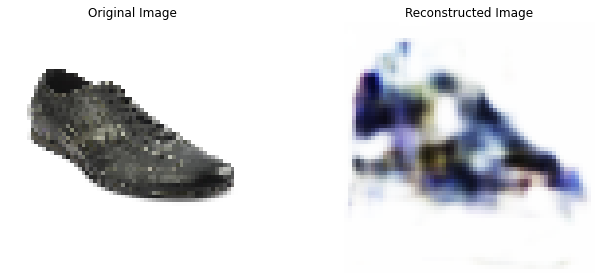

In [17]:
##PLOTING IMAGES FOR EVALUATION####

#image_path = '/notebooks/examples/1164.jpg'
#image_path = '/notebooks/examples/result_image_1688505367634.jpg'  # Replace with your image path
#image_path = '/notebooks/examples/result_image_1688505367634.jpg'  # Replace with your image path
image_path = '/home/thanos/Desktop/Sustainable_fashion/data/test_images/2393.jpg'
original_image = preprocess_image_2(image_path)

# Add a new axis to make it a batch of size 1
original_image_batch = np.expand_dims(original_image, axis=0)

# Get the autoencoder's reconstruction
reconstructed_image = loaded_autoencoder.predict(original_image_batch)

# Display the original and reconstructed images using matplotlib
plt.figure(figsize=(10, 4))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')

# Reconstructed image
plt.subplot(1, 2, 2)
plt.imshow(reconstructed_image[0])
plt.title('Reconstructed Image')
plt.axis('off')

plt.tight_layout()
plt.show()

In [28]:
loaded_encoder = load_model('/home/thanos/Desktop/Sustainable_fashion/data/models/Models_autoencoders/Shoes_embedding_model.h5')


In [9]:
image_path = '/home/thanos/Desktop/Sustainable_fashion/data/test_images/2393.jpg'

In [19]:
image_with_embd = get_emb_from__ext_img(image_path,loaded_encoder)


1/1 [==============================] - 0s 36ms/step


In [24]:
with open('/home/thanos/Desktop/Sustainable_fashion/data/polyvore_vong/polyvore_1000_cleaned/pickle_files/Tops.pkl', "rb") as f:
    features = pickle.load(f)

In [ ]:
df = pd.DataFrame(features)

In [37]:
import pickle
import numpy as np


# List of categories
categories = ["Tops", "Bottoms", "Bags", "Outwear", "Onepieces", "Shoes", "Accessories"]

# Initialize lists to hold data and labels
all_data = []
all_labels = []

# Loop through each category
for category in categories:
    # Construct the file path
    file_path = f"/home/thanos/Desktop/Sustainable_fashion/data/polyvore_vong/polyvore_1000_cleaned/pickle_files/{category}.pkl"
    
    # Load the data
    with open(file_path, "rb") as f:
        features = pickle.load(f)
    
    # Append the loaded data and labels to the lists
    all_data.append(features)
    all_labels.append(np.full((features.shape[0],), category))

# Concatenate all data and labels along the first axis
all_data = np.concatenate(all_data, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

In [38]:
categories = ["Tops", "Bottoms", "Bags", "Outwear", "Onepieces", "Shoes", "Accessories"]

# Initialize a list to store the embeddings
all_embeddings = []

# Loop through each category
for category in categories:
    # Construct the file path
    model_path = f"/home/thanos/Desktop/Sustainable_fashion/data/models/Models_autoencoders/{category}_embedding_model.h5"
    
    # Load the encoder model
    encoder = load_model(model_path, compile=False)  # Use compile=False if you only need to forward-pass
    
    # Find the indices of images belonging to the current category
    idx = np.where(all_labels == category)[0]
    
    # Extract the subset of images belonging to the current category
    category_images = all_data[idx]
    
    # Generate embeddings using the encoder
    embeddings = encoder.predict(category_images)
    
    # You might want to keep track of embeddings along with their labels.
    # For simplicity, and to keep them in order, we'll append them to a list first
    all_embeddings.append(embeddings)

# After looping through all categories, concatenate all embeddings along the first axis
all_embeddings = np.concatenate(all_embeddings, axis=0)

26/26 [==============================] - 11s 420ms/step


In [40]:
all_embeddings.shape

(6395, 16)

In [36]:
embeddings.shape

(871, 16)

In [31]:
idx

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [29]:
loaded_encoder.predict(all_data)

200/200 [==============================] - 85s 421ms/step


array([[0.00269133, 0.00822546, 0.00019723, ..., 0.        , 0.        ,
        0.        ],
       [0.0058361 , 0.00549791, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00576472, 0.00523382, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.00527093, 0.00608881, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00628074, 0.0049903 , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00373923, 0.00434462, 0.00034376, ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [6]:
all_labels.shape

(6395,)

In [8]:
all_data.shape

(6395, 64, 64, 3)

In [9]:
all_labels

array(['Tops', 'Tops', 'Tops', ..., 'Accessories', 'Accessories',
       'Accessories'], dtype='<U11')

In [ ]:
all_embeddings

In [46]:
idx = np.random.choice(len(all_embeddings), 1000)
inputs = all_data[idx]

In [47]:
all_data.shape

(6395, 64, 64, 3)

In [62]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

def plot_latent(mode, count, technique):
    idx = np.random.choice(len(all_embeddings), count)
    inputs = all_data[idx]
    embed = all_embeddings[idx]
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.set_title(technique)
    if technique == 'pca':
        coords = PCA(n_components=2).fit_transform(embed.reshape(count, -1))
    elif technique == 'tsne':
        coords = TSNE(n_components=2).fit_transform(embed.reshape(count, -1))

    if mode == 'imgs':
        for image, (x, y) in zip(inputs, coords):
            im = cv2.resize(image, (14,14))
            im = OffsetImage(im, zoom=1, cmap='gray')
            ab = AnnotationBbox(im, (x, y), xycoords='data', frameon=False)
            ax.add_artist(ab)
        ax.update_datalim(coords)
        ax.autoscale()
    # elif mode == 'dots':
    #     classes = all_labels[idx]
    #     plt.scatter(coords[:, 0], coords[:, 1], c=classes)
    #     plt.colorbar()
    #     for i in range(10):
    #         class_center = np.mean(coords[classes == i], axis=0)
    #         text = TextArea('{} ({})'.format(categories[i], i))
    #         ab = AnnotationBbox(text, class_center, xycoords='data', frameon=True)
    #         ax.add_artist(ab)
    plt.show()    

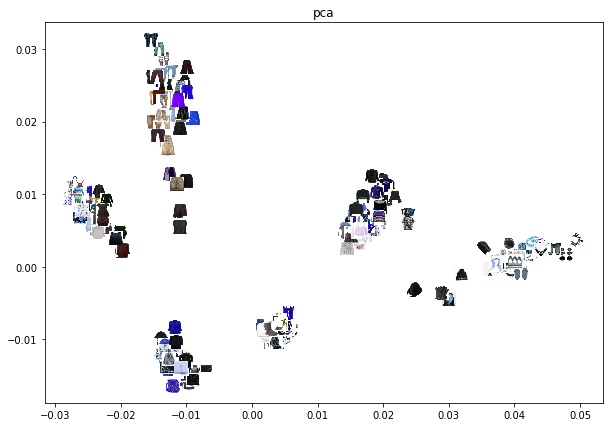

In [63]:
plot_latent('imgs', 300, 'pca')


In [24]:
coords.shape

(1000, 2)

In [26]:
inputs.shape

(1000, 64, 64, 3)

In [13]:
encoder.outputs

[<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_2')>]